# Stellar classification: stars, quasars and galaxies

### Importing modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
# Our modules
import metrics_tools
import models_testing
import scaling

### Reading the dataset

In [2]:
df = pd.read_csv("dataset/star_classification.csv")
df = df[["obj_ID", "alpha", "delta", "u", "g", "r", "i", "z", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "redshift", "plate", "MJD", "fiber_ID", "class"]]
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171,GALAXY
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427,GALAXY
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299,GALAXY
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775,GALAXY
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842,GALAXY


### Encoding the labels

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(df["class"])
df["class"] = label_encoder.transform(df["class"])

In [4]:
print(label_encoder.classes_)

['GALAXY' 'QSO' 'STAR']


## Correllation matrix

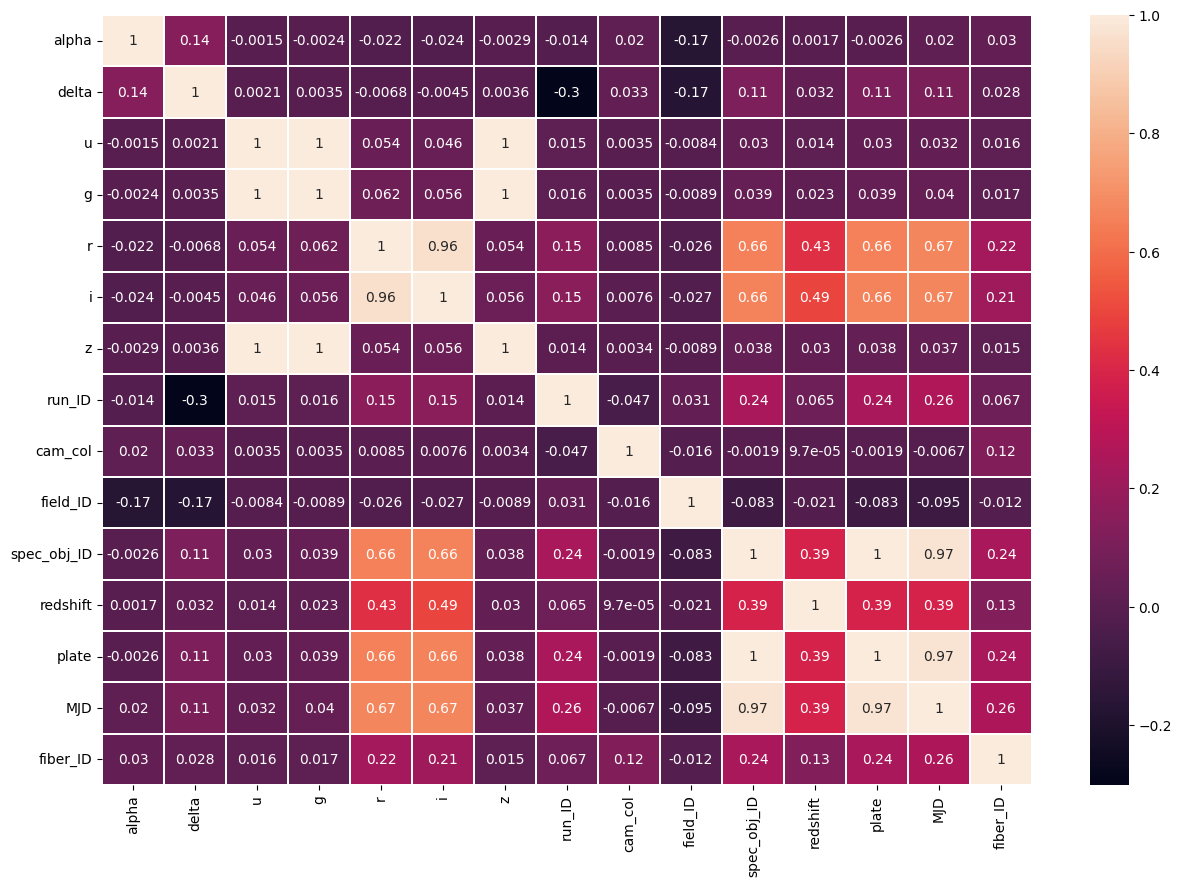

In [5]:
metrics_tools.corr_matrix(df.drop(["class", "obj_ID", "rerun_ID"], axis = 1).corr())

### VIF - Variance Inflance Factor

In [6]:
metrics_tools.variance_inflation(df)

/Users/genna/.pyenv/versions/acsai/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


       Variable           VIF
0        obj_ID  5.612779e-10
1         alpha  1.000006e+00
2         delta  1.012774e+00
3             u  1.000901e+00
4             g  1.001558e+00
5             r  1.752373e+00
6             i  1.778624e+00
7             z  1.001432e+00
8        run_ID  1.060856e+00
9      rerun_ID  0.000000e+00
10      cam_col  1.000002e+00
11     field_ID  1.007017e+00
12  spec_obj_ID  2.351782e+02
13     redshift  1.177915e+00
14        plate  2.090999e+09
15          MJD  1.701719e+01
16     fiber_ID  1.061814e+00
17        class  1.000101e+00


## Restricting the feature space

Let's remove the non-correlated features; moreover, let's delete also "plate" variable, which seems to have a very-high VIF.

In [7]:
features = [# List of features with stronger degree of linear correlation to keep in the dataframe
    "u",    # Ultraviolet filter in the photometric system
    "g",    # Green filter in the photometric system
    "i",    # Near Infrared filter in the photometric system
    "r",    # Red filter in the photometric system
    "z",    # Infrared filter in the photometric system
    "MJD",  # Modified Julian Date
    "spec_obj_ID", # Unique ID used for optical spectroscopic objects
    "redshift", # Redshift value based on the increase in wavelength
    "fiber_ID", # Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation
    "class" # Object class
          ]
df = df[features]

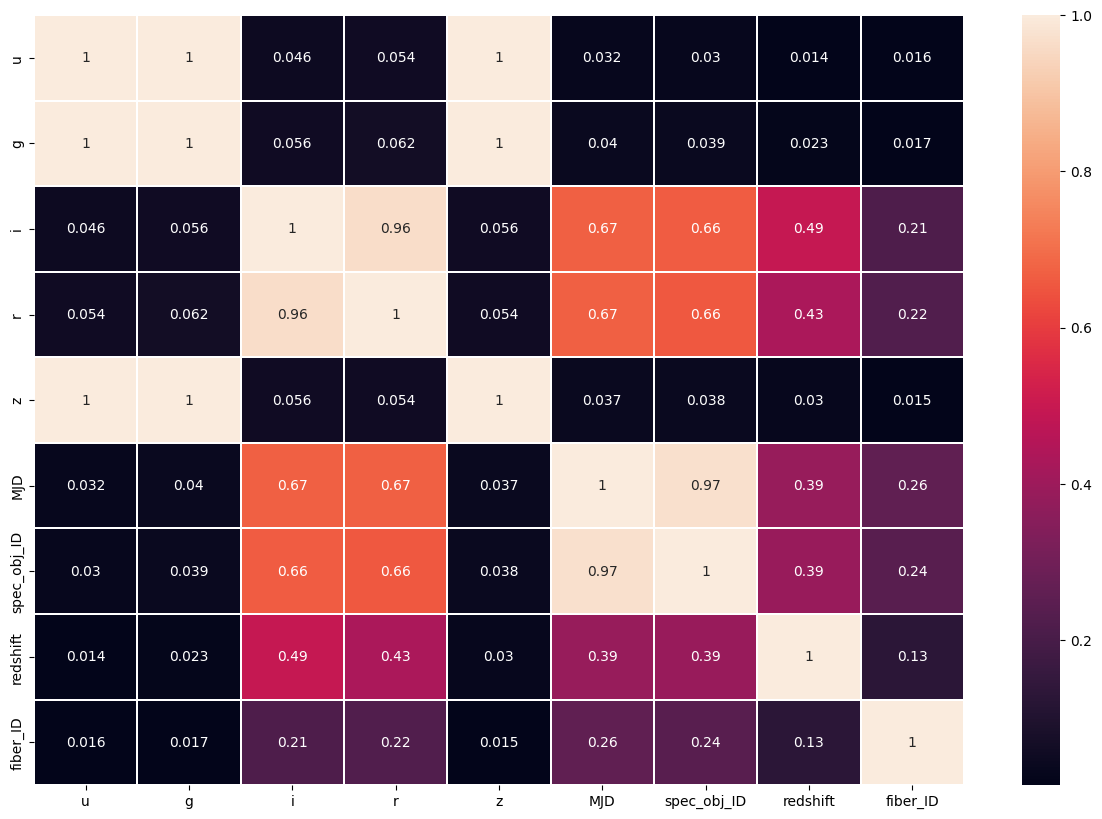

In [8]:
metrics_tools.corr_matrix(df.drop(["class"], axis=1).corr())

## Scaling the dataset

Before taking data to the model, it's necessary to scale the dataset (i.e. standardize the data through z-score) in order to reduce the gap between orders of magnitude for each feature to make them comparable.
Furthermore, to ensure balance in the dataset, we apply [SMOTE-Tomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) hybrid sampling.

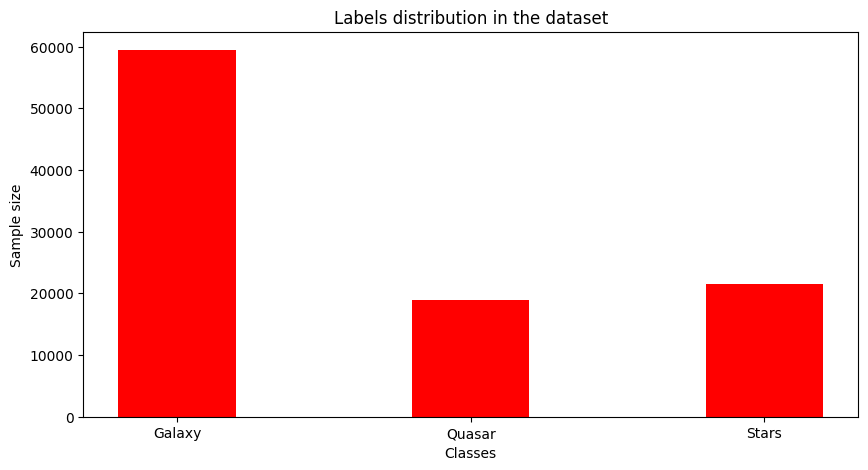

In [9]:
metrics_tools.plotLabels(df["class"]) 

As we can see, there's a very **high imbalance between the classes**... Let's solve this problem!

In [10]:
data, X, y = scaling.scale_dataset(df) # Pass balance=False to unable hybrid sampling

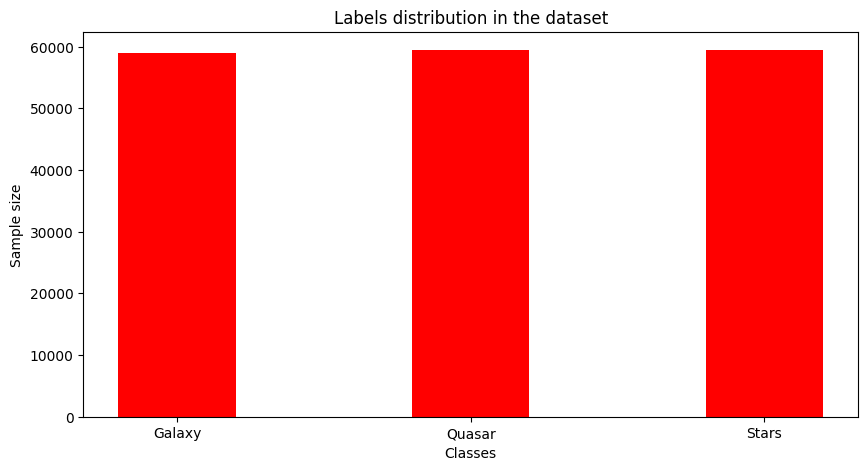

In [11]:
metrics_tools.plotLabels(y)

## Train-test dataset split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Random forest

Let's build a grid to see which are the best hyperparameters - i.e. **n_estimators** and **max_depth**. Note that, in order to do that, **k-fold cross validation**. This is because the training set is split into k-subfolds and, for each combination of the parameters, the model is trained on (k-1) of them and tested on the k-th. 

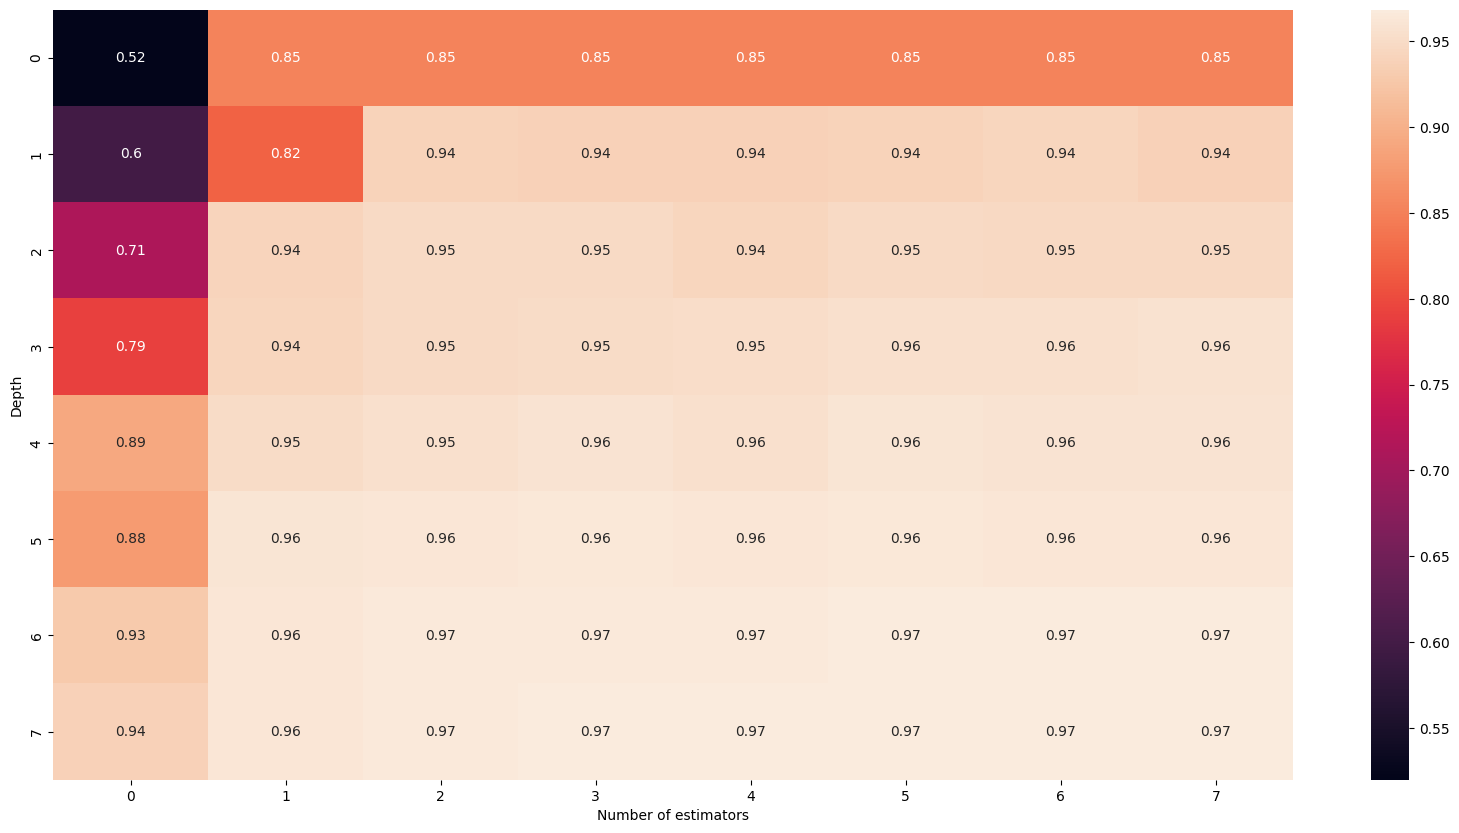

In [13]:
hyperparam_RFC = models_testing.hyperparam_test_RFC(X_train, y_train, X_test, y_test, 'entropy', 'sqrt')
metrics_tools.plot_scores(hyperparam_RFC, "RFC")

# Decision tree

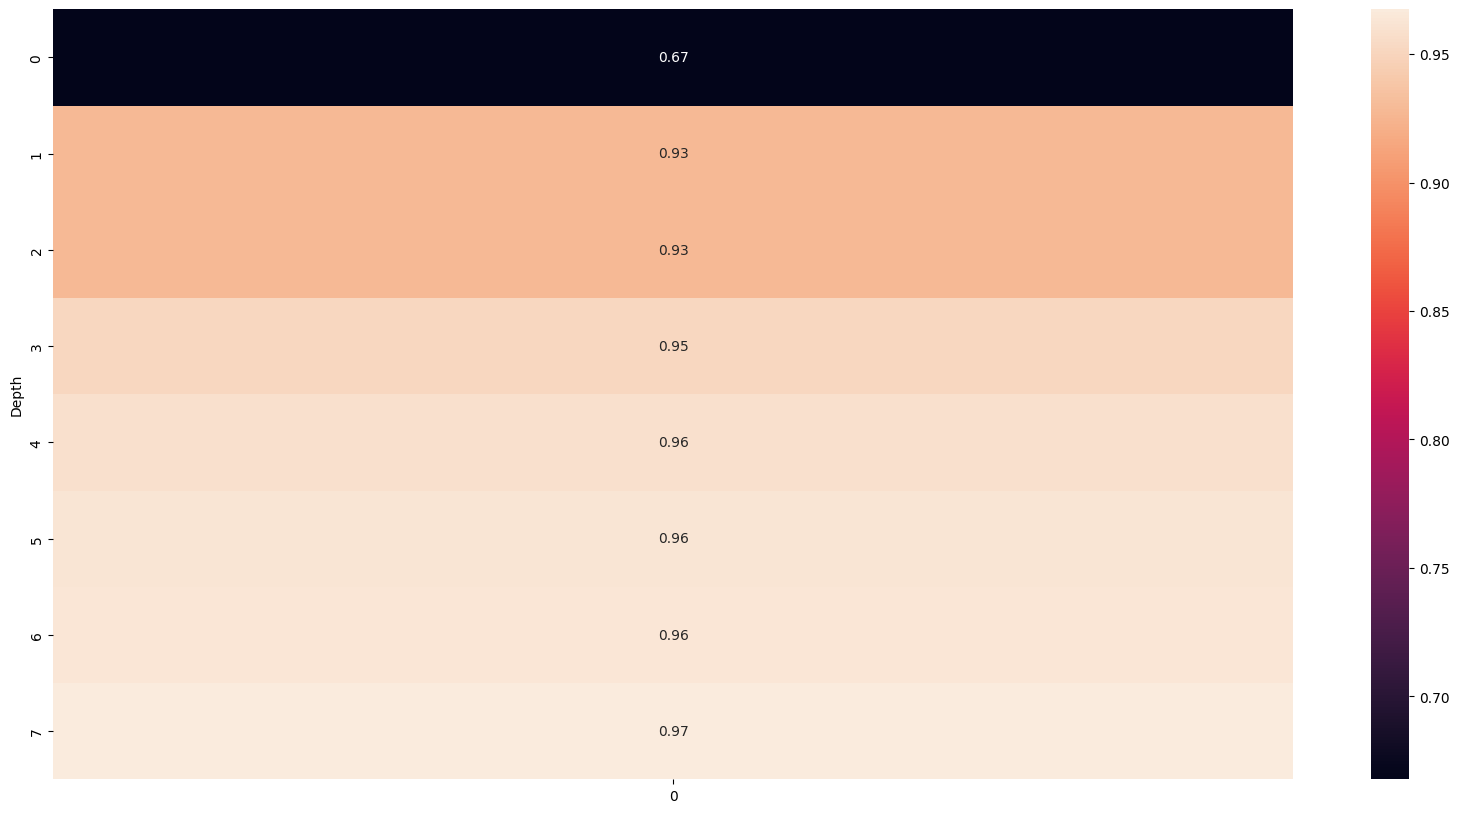

In [14]:
hyperparam_DTC = models_testing.hyperparam_test_DTC(X_train, y_train, X_test, y_test, 'entropy')
metrics_tools.plot_scores(hyperparam_DTC, "DTC")

## Random forest: max_depth = 7, n_estimators = 5

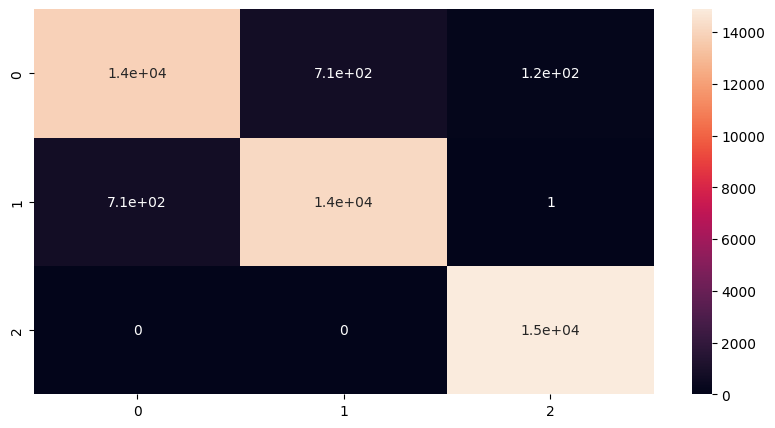

In [21]:
RFC = RandomForestClassifier(
    max_depth = 7, # Number of levels in each of the DT
    criterion = 'entropy', # Impurity function used
    n_estimators = 5, # Number of trees in the forest
    min_impurity_decrease = 0.001, # Minimum decrease in impurity for being selected as splitting feature/value
    max_features = 'sqrt', # Number of features to use with each of the decision tree
    random_state = 0
)

RFC.fit(X_train, y_train)
y_pred_RFC = RFC.predict(X_test)
confusion_matrix_RFC = np.array(metrics.confusion_matrix(y_test, y_pred_RFC))
metrics_tools.plot_confusion_matrix(confusion_matrix_RFC)

In [22]:
true_pos_RFC = np.diag(confusion_matrix_RFC)
false_pos_RFC = np.sum(confusion_matrix_RFC, axis=0) - true_pos_RFC
false_neg_RFC = np.sum(confusion_matrix_RFC, axis=1) - true_pos_RFC

accuracy_RFC = metrics.accuracy_score(y_test, y_pred_RFC)
precision_RFC = np.array(true_pos_RFC / (true_pos_RFC + false_pos_RFC)).mean()
recall_RFC = np.array(true_pos_RFC / (true_pos_RFC + false_neg_RFC)).mean()

In [23]:
print("RANDOM FOREST: \nAccuracy:, %1.5f \nPrecision: %1.5f \nRecall: %1.5f" %(accuracy_RFC, precision_RFC, recall_RFC))

RANDOM FOREST: 
Accuracy:, 0.96527 
Precision: 0.96510 
Recall: 0.96518


## Decision tree: max_depth = 7

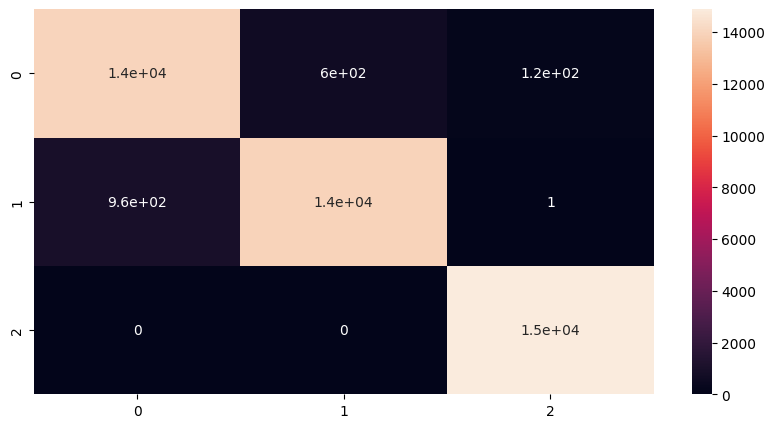

In [24]:
DTC = tree.DecisionTreeClassifier(
    max_depth = 7, # Number of levels in each of the DT
    criterion = 'entropy', # Impurity function used
    min_impurity_decrease = 0.001, # Minimum decrease in impurity for being selected as splitting feature/value
    random_state = 0
)

DTC.fit(X_train, y_train)
y_pred_DTC = DTC.predict(X_test)
confusion_matrix_DTC = np.array(metrics.confusion_matrix(y_test, y_pred_DTC))
metrics_tools.plot_confusion_matrix(confusion_matrix_DTC)

In [25]:
true_pos_DTC = np.diag(confusion_matrix_DTC)
false_pos_DTC = np.sum(confusion_matrix_DTC, axis=0) - true_pos_DTC
false_neg_DTC = np.sum(confusion_matrix_DTC, axis=1) - true_pos_DTC

accuracy_DTC = metrics.accuracy_score(y_test, y_pred_DTC)
precision_DTC = np.array(true_pos_DTC / (true_pos_DTC + false_pos_DTC)).mean()
recall_DTC = np.array(true_pos_DTC / (true_pos_DTC + false_neg_DTC)).mean()

In [26]:
print("DECISION TREE: \nAccuracy:, %1.5f \nPrecision: %1.5f \nRecall: %1.5f" %(accuracy_DTC, precision_DTC, recall_DTC))

DECISION TREE: 
Accuracy:, 0.96203 
Precision: 0.96195 
Recall: 0.96199
